# Calibracion estereo y computo de mapas de rectificacion

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import glob

In [56]:
# Directorio base de los resultados de calibración
base_dir = "imgs/calibracion"

# Ruta al archivo existente de calibración estéreo
calib_file = os.path.join(base_dir, "stereo_calibration.pkl")

# Cargar la calibración
with open(calib_file, "rb") as f:
    calib = pickle.load(f)

# Imprimir los parámetros de calibración
def np_print(name, arr):
    np.set_printoptions(precision=4, suppress=True)
    print(f"\n{name} =\n{arr}")

print("### PARÁMETROS DE CALIBRACIÓN ESTÉREO ###")
np_print("Matriz intrínseca cámara izquierda (K1)", calib["left_K"])
np_print("Coef. distorsión izquierda (d1)", calib["left_dist"])
np_print("Matriz intrínseca cámara derecha (K2)", calib["right_K"])
np_print("Coef. distorsión derecha (d2)", calib["right_dist"])
np_print("Rotación (R)", calib["R"])
np_print("Traslación (T)", calib["T"])
np_print("Matriz esencial (E)", calib["E"])
np_print("Matriz fundamental (F)", calib["F"])

### PARÁMETROS DE CALIBRACIÓN ESTÉREO ###

Matriz intrínseca cámara izquierda (K1) =
[[596.3832   0.     950.5001]
 [  0.     596.4378 515.5356]
 [  0.       0.       1.    ]]

Coef. distorsión izquierda (d1) =
[[ 0.0211 -0.0344 -0.0066 -0.0004  0.0058]]

Matriz intrínseca cámara derecha (K2) =
[[595.3381   0.     944.1087]
 [  0.     595.7354 513.5429]
 [  0.       0.       1.    ]]

Coef. distorsión derecha (d2) =
[[ 0.0145 -0.0287 -0.0061 -0.0014  0.0042]]

Rotación (R) =
[[ 1.      0.0019  0.0069]
 [-0.0019  1.     -0.0002]
 [-0.0069  0.0001  1.    ]]

Traslación (T) =
[[-58.9755]
 [ -0.0693]
 [ -1.1424]]

Matriz esencial (E) =
[[ -0.0017   1.1424  -0.0695]
 [ -1.5471   0.0061  58.9663]
 [  0.18   -58.9752   0.0094]]

Matriz fundamental (F) =
[[ 0.     -0.      0.003 ]
 [ 0.     -0.     -0.1773]
 [-0.0044  0.1752  1.    ]]


In [57]:
# Extraer los parámetros necesarios
left_K = calib["left_K"]
left_dist = calib["left_dist"]
right_K = calib["right_K"]
right_dist = calib["right_dist"]
R = calib["R"]
T = calib["T"]

# Si pickle no tiene 'image_size', lo inferimos leyendo una imagen del dataset
if "image_size" in calib:
    image_size = calib["image_size"]
else:
    sample_img = cv2.imread(sorted(glob.glob(os.path.join(base_dir, "*left*.jpg"))[0]))
    image_size = (sample_img.shape[1], sample_img.shape[0])  # (w, h)
    print("⚠️ 'image_size' no estaba en el pickle, se infirió como:", image_size)

# Calcular la rectificación estéreo
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist,
    right_K, right_dist,
    image_size,
    R, T,
    alpha=0
)

# Generar los mapas de rectificación
left_map_x, left_map_y = cv2.initUndistortRectifyMap(
    left_K, left_dist, R1, P1, image_size, cv2.CV_32FC1
)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(
    right_K, right_dist, R2, P2, image_size, cv2.CV_32FC1
)

# Guardar los mapas en un nuevo pickle
stereo_maps = {
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,
    "R1": R1,
    "R2": R2,
    "P1": P1,
    "P2": P2,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,
}

maps_file = os.path.join(base_dir, "stereo_maps.pkl")
with open(maps_file, "wb") as f:
    pickle.dump(stereo_maps, f)

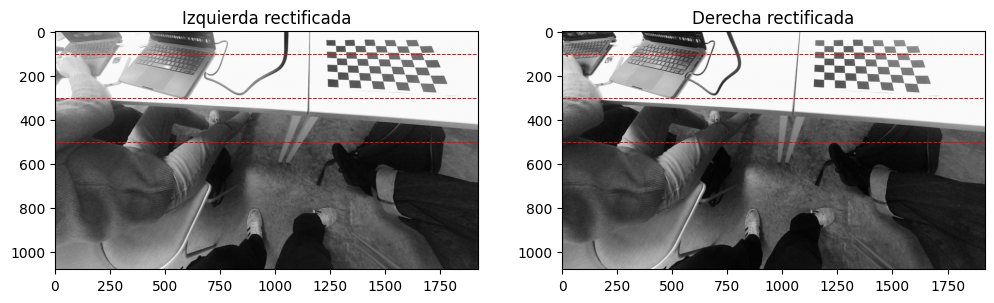

In [58]:
# Mostrar ejemplo de par de imagenes des-distorsionadas y rectificadas

# Cargar los mapas de rectificación
with open("imgs/calibracion/stereo_maps.pkl", "rb") as f:
    maps = pickle.load(f)

left_map_x, left_map_y = maps["left_map_x"], maps["left_map_y"]
right_map_x, right_map_y = maps["right_map_x"], maps["right_map_y"]

# Tomar un par de imágenes de calibración
left_img_path = sorted(glob.glob("imgs/calibracion/*left*.jpg"))[0]
right_img_path = sorted(glob.glob("imgs/calibracion/*right*.jpg"))[0]

imgL = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

# Aplicar rectificación
rectL = cv2.remap(imgL, left_map_x, left_map_y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR, right_map_x, right_map_y, cv2.INTER_LINEAR)

# Mostrar
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(rectL, cmap="gray")
axes[0].set_title("Izquierda rectificada")
axes[1].imshow(rectR, cmap="gray")
axes[1].set_title("Derecha rectificada")

# Dibujar líneas horizontales para verificar alineación epipolar
for y in [100, 300, 500]:
    axes[0].axhline(y, color='r', linestyle='--', linewidth=0.7)
    axes[1].axhline(y, color='r', linestyle='--', linewidth=0.7)

plt.show()

# Rectificacion, disparidad y profundidad

## Rectificar los pares de imagenes del dataset de reconstruccion

In [59]:
def rectificar_imagenes(path_imgs, path_maps):
    """
    Rectifica todos los pares de imágenes estéreo (left/right) de un directorio usando mapas precomputados.
    
    Parámetros:
        path_imgs (str): Carpeta que contiene las imágenes 'left_*.jpg' y 'right_*.jpg'
        path_maps (str): Ruta al archivo 'stereo_maps.pkl'
    """
    # Crear carpeta de salida si no existe
    output_dir = os.path.join(path_imgs, "rectificadas")
    os.makedirs(output_dir, exist_ok=True)

    # Cargar los mapas de rectificación
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    left_map_x, left_map_y = maps["left_map_x"], maps["left_map_y"]
    right_map_x, right_map_y = maps["right_map_x"], maps["right_map_y"]

    # Buscar las imágenes left y right
    left_imgs = sorted(glob.glob(os.path.join(path_imgs, "left_*.jpg")))
    right_imgs = sorted(glob.glob(os.path.join(path_imgs, "right_*.jpg")))

    if len(left_imgs) != len(right_imgs):
        print("⚠️ Cantidad distinta de imágenes left/right")
        print(f"Left: {len(left_imgs)}, Right: {len(right_imgs)}")
        return

    print(f"🔹 Rectificando {len(left_imgs)} pares de imágenes...")

    for left_path, right_path in zip(left_imgs, right_imgs):
        # Leer imágenes
        imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
        imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

        # Rectificar
        rectL = cv2.remap(imgL, left_map_x, left_map_y, cv2.INTER_LINEAR)
        rectR = cv2.remap(imgR, right_map_x, right_map_y, cv2.INTER_LINEAR)

        # Nombres de salida
        baseL = os.path.basename(left_path)
        baseR = os.path.basename(right_path)
        outL = os.path.join(output_dir, f"rect_{baseL}")
        outR = os.path.join(output_dir, f"rect_{baseR}")

        # Guardar
        cv2.imwrite(outL, rectL)
        cv2.imwrite(outR, rectR)

    print(f"✅ Imágenes rectificadas guardadas en: {output_dir}")

rectificar_imagenes("imgs/objeto", "imgs/calibracion/stereo_maps.pkl")

🔹 Rectificando 21 pares de imágenes...
✅ Imágenes rectificadas guardadas en: imgs/objeto/rectificadas


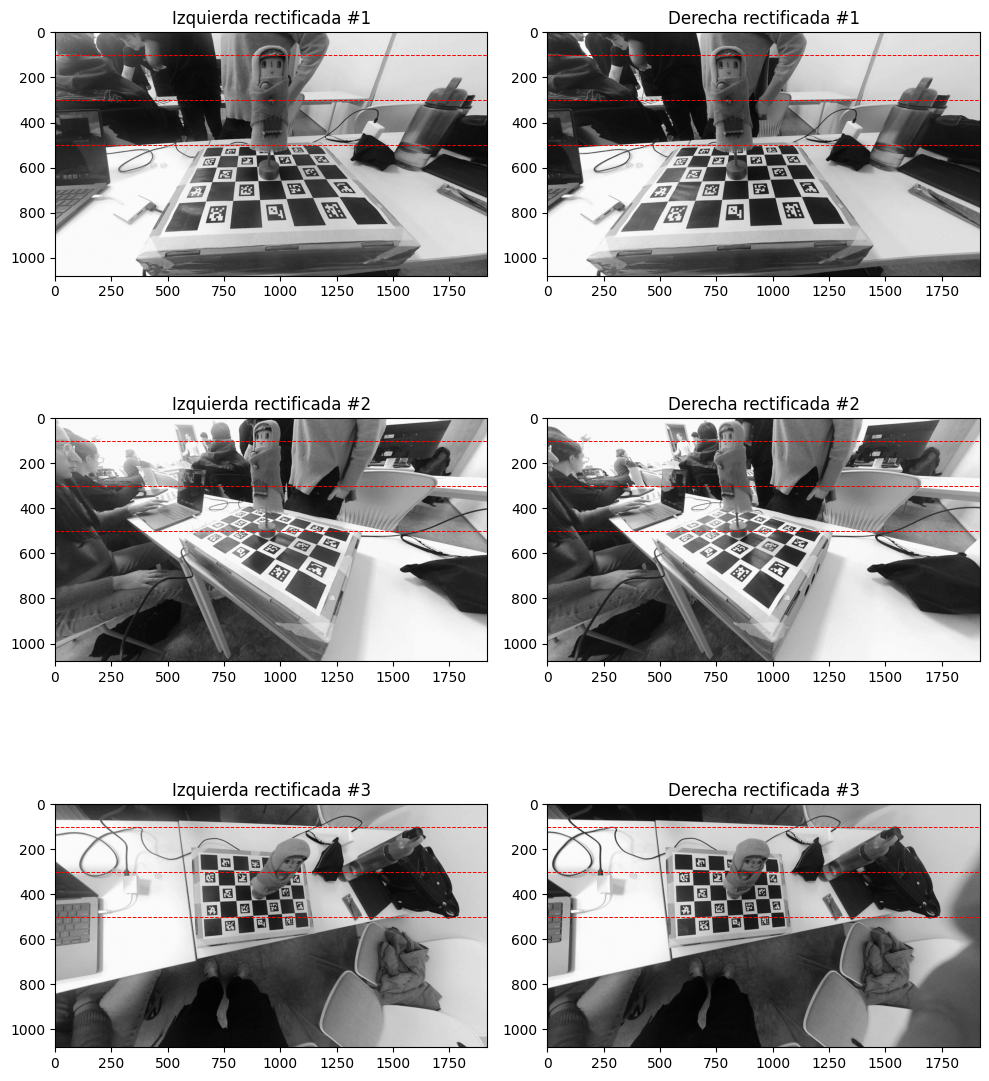

In [60]:
# Mostrar varios pares de imágenes rectificadas con líneas epipolares
left_imgs = sorted(glob.glob("imgs/objeto/rectificadas/rect_left_*.jpg"))
right_imgs = sorted(glob.glob("imgs/objeto/rectificadas/rect_right_*.jpg"))

n_ejemplos = 3  # cuántos pares querés mostrar
fig, axes = plt.subplots(n_ejemplos, 2, figsize=(10, 4 * n_ejemplos))

for i in range(n_ejemplos):
    imgL = cv2.imread(left_imgs[i], cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_imgs[i], cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(imgL, cmap="gray")
    axes[i, 0].set_title(f"Izquierda rectificada #{i+1}")
    axes[i, 1].imshow(imgR, cmap="gray")
    axes[i, 1].set_title(f"Derecha rectificada #{i+1}")

    # líneas epipolares
    for y in [100, 300, 500]:
        axes[i, 0].axhline(y, color='r', linestyle='--', linewidth=0.7)
        axes[i, 1].axhline(y, color='r', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()


## Disparidad de la escena

In [61]:
def calcular_mapa_disparidad(imgL, imgR):
    """
    Calcula el mapa de disparidad usando el algoritmo SGBM.
    Devuelve el mapa crudo, listo para la reconstrucción 3D.
    """
    # USAMOS SGBM (Semi-Global Block Matching)
    # Falta ajustar los parámetros a mano!
    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,
        blockSize=12,
        P1=8 * 3 * blockSize**2,
        P2=32 * 3 * blockSize**2,
        disp12MaxDiff=1,
        uniquenessRatio=8,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # Calcular el mapa de disparidad crudo
    disparity_raw = stereo_sgbm.compute(imgL, imgR)
    
    return disparity_raw

In [62]:
def procesar_dataset_completo(path_rectificadas, output_path):
    """
    Carga todos los pares de imágenes, calcula la disparidad y guarda los
    resultados en subcarpetas 'crudo' y 'visual'.
    """
    print("🔹 Iniciando el proceso de Stereo Matching para todo el dataset...")
    
    # --- MODIFICACIÓN: Crear subcarpetas para los resultados ---
    path_crudo = os.path.join(output_path, 'crudo')
    path_visual = os.path.join(output_path, 'visual')
    os.makedirs(path_crudo, exist_ok=True)
    os.makedirs(path_visual, exist_ok=True)
    # --- Fin de la modificación ---

    left_images = sorted(glob.glob(os.path.join(path_rectificadas, 'rect_left_*.jpg')))
    right_images = sorted(glob.glob(os.path.join(path_rectificadas, 'rect_right_*.jpg')))

    if not left_images or len(left_images) != len(right_images):
        print(f"❌ Error: No se encontraron pares de imágenes consistentes en '{path_rectificadas}'.")
        return

    print(f"Se encontraron {len(left_images)} pares de imágenes.")

    for i, (left_path, right_path) in enumerate(zip(left_images, right_images)):
        print(f"  Procesando par {i+1}/{len(left_images)}...")
        
        imgL = cv2.imread(left_path, 0)
        imgR = cv2.imread(right_path, 0)

        disparity_raw = calcular_mapa_disparidad(imgL, imgR)

        file_basename = os.path.basename(left_path).replace('rect_left_', '').replace('.jpg', '')
        
        # --- MODIFICACIÓN: Guardar en la carpeta 'crudo' ---
        np.save(os.path.join(path_crudo, f'disp_raw_{file_basename}.npy'), disparity_raw)

        # --- MODIFICACIÓN: Guardar en la carpeta 'visual' ---
        disparity_visual = cv2.normalize(disparity_raw, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        disparity_color = cv2.applyColorMap(disparity_visual, cv2.COLORMAP_PLASMA)
        cv2.imwrite(os.path.join(path_visual, f'disp_visual_{file_basename}.jpg'), disparity_color)

    print(f"\n✅ Proceso completado. Mapas de disparidad guardados en:")
    print(f"   - Datos crudos: {path_crudo}")
    print(f"   - Imágenes visuales: {path_visual}")

In [63]:
# path_rectificadas = "imgs/objeto/rectificadas"
# path_salida_disparidad = "imgs/objeto/disparidad" # Carpeta principal de salida

# procesar_dataset_completo(path_rectificadas, path_salida_disparidad)

Las imágenes se guardaron en objeto/disparidad/visual --> para verlas y en objeto/disparidad/crudo para despues usar los números.

### Mapa de Disparidad



In [64]:
def calcular_mapa_disparidad(imgL, imgR, build_matcher_fn, **kwargs):
    """
    Calcula el mapa de disparidad usando un builder genérico (SGBM, BM, etc.)
    
    Args:
        imgL, imgR: imágenes rectificadas (en escala de grises)
        build_matcher_fn: función que construye el objeto stereo (ej: make_sgbm o make_bm)
        **kwargs: parámetros adicionales que se pasan al builder

    Returns:
        disparity_raw: mapa de disparidad crudo (float32)
        disparity_vis: mapa normalizado para visualización (uint8)
    """
    assert imgL.ndim == 2 and imgR.ndim == 2, "Usar imágenes en gris (1 canal)"
    assert imgL.shape == imgR.shape, "Ambas imágenes deben tener igual tamaño"

    # Crear el matcher según el builder que pases
    stereo = build_matcher_fn(**kwargs)

    # Calcular disparidad cruda
    disparity_raw = stereo.compute(imgL, imgR)

    # Normalizar para visualización
    disparity_vis = cv2.normalize(disparity_raw, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return disparity_raw, disparity_vis


### BM

In [65]:
def make_bm(num_disp=16*12, block=15, *,
            preFilterType=cv2.STEREO_BM_PREFILTER_XSOBEL,
            preFilterSize=9, preFilterCap=31,
            textureThreshold=10, uniquenessRatio=5,
            speckleRange=32, speckleWindowSize=100):
    """
    Crea un matcher StereoBM de OpenCV.
    - num_disp: múltiplo de 16 (rango de disparidad).
    - block: impar en [5..51] (ventana de correlación).
    """
    assert num_disp % 16 == 0, "num_disp debe ser múltiplo de 16"
    assert block % 2 == 1 and 5 <= block <= 51, "block debe ser impar en [5..51]"

    bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block)
    bm.setPreFilterType(preFilterType)
    bm.setPreFilterSize(preFilterSize)
    bm.setPreFilterCap(preFilterCap)
    bm.setTextureThreshold(textureThreshold)
    bm.setUniquenessRatio(uniquenessRatio)
    bm.setSpeckleRange(speckleRange)
    bm.setSpeckleWindowSize(speckleWindowSize)
    return bm


In [66]:
# Seleccionar los mismos tres pares de imágenes rectificadas
pares_indices = [0, 1, 2]  # o los que quieras mantener fijos
pares_imgs = [(left_imgs[i], right_imgs[i]) for i in pares_indices]

# Guardar la selección para usar en ambos métodos
print("Pares seleccionados:")
for idx, (l, r) in zip(pares_indices, pares_imgs):
    print(f"  Par {idx+1}:")
    print(f"    Left → {os.path.basename(l)}")
    print(f"    Right → {os.path.basename(r)}")


Pares seleccionados:
  Par 1:
    Left → rect_left_0.jpg
    Right → rect_right_0.jpg
  Par 2:
    Left → rect_left_1.jpg
    Right → rect_right_1.jpg
  Par 3:
    Left → rect_left_10.jpg
    Right → rect_right_10.jpg


BM – Par 1 → min: -16.0, max: 3056.0


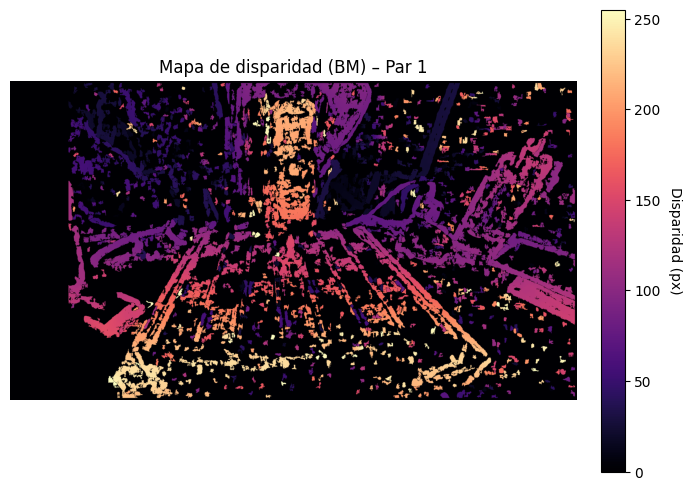

BM – Par 2 → min: -16.0, max: 3056.0


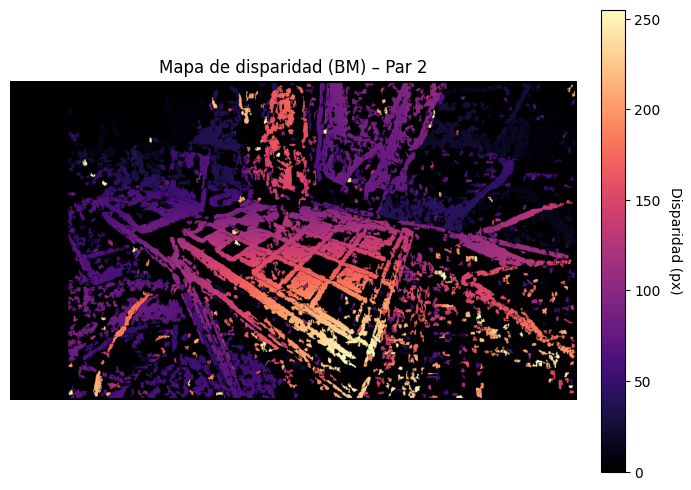

BM – Par 3 → min: -16.0, max: 3056.0


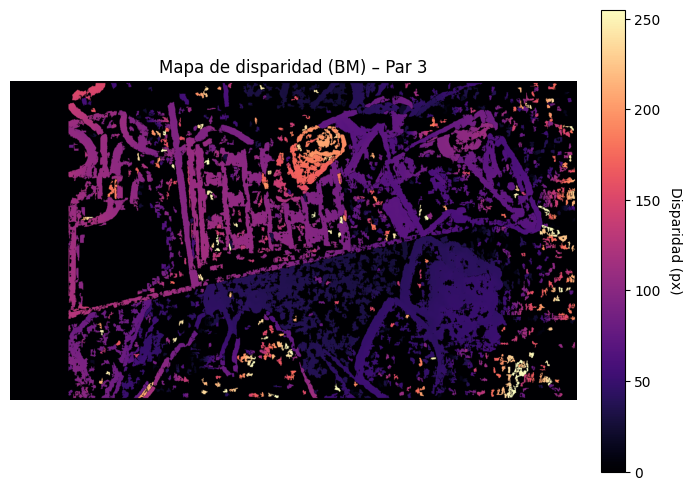

In [67]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# --- BM ---
for idx, (left_path, right_path) in zip(pares_indices, pares_imgs):
    imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

    disp_raw, disp_vis = calcular_mapa_disparidad(
        imgL, imgR,
        build_matcher_fn=make_bm,
        num_disp=16*12,
        block=15,
        textureThreshold=10,
        uniquenessRatio=5,
        speckleRange=32,
        speckleWindowSize=100
    )

    print(f"BM – Par {idx+1} → min: {disp_raw.min():.1f}, max: {disp_raw.max():.1f}")

    plt.figure(figsize=(8,6))
    im = plt.imshow(disp_vis, cmap="magma")
    plt.title(f"Mapa de disparidad (BM) – Par {idx+1}")
    plt.axis("off")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Disparidad (px)", rotation=270, labelpad=15)
    plt.show()

#### Busqueda de Hiperparametros BM

In [68]:
import time, numpy as np, cv2, itertools
from collections import defaultdict

def pct_valid(disp_raw):
    return float(np.mean(disp_raw > 0) * 100.0)

def smoothness_score(disp_vis_uint8):
    # Menor varianza del gradiente = más suave (menos ruido)
    gx = cv2.Sobel(disp_vis_uint8, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(disp_vis_uint8, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    # Invertimos para que "más suave" dé score mayor
    return 1.0 / (np.var(grad) + 1e-6)

def evaluate_matcher(imgL, imgR, build_matcher_fn, **kwargs):
    """
    Corre el matcher y devuelve: tiempo, %válidos, suavidad y vis.
    """
    t0 = time.time()
    stereo = build_matcher_fn(**kwargs)
    disp_raw = stereo.compute(imgL, imgR)
    elapsed = time.time() - t0

    disp_vis = cv2.normalize(disp_raw, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    disp_vis = cv2.medianBlur(disp_vis, 5)
    return {
        "time_s": elapsed,
        "pct_valid": pct_valid(disp_raw),
        "smooth": smoothness_score(disp_vis),
        "disp_raw": disp_raw,
        "disp_vis": disp_vis
    }


In [69]:
# Define tu grilla (mantén reglas: num_disp múltiplo de 16, block impar)
bm_grid = {
    "num_disp": [16*10, 16*12, 16*14, 16*16],
    "block":    [9, 11, 15, 19],
    "textureThreshold": [5, 10, 20],
    "uniquenessRatio":  [5, 8, 12],
}

def grid_search_bm(pares_imgs, n_eval=3):
    """
    Recorre la grilla en los primeros n_eval pares (o los que pases).
    Devuelve el mejor set + tabla de resultados agregados.
    """
    results = []
    # Seleccionamos pares
    subset = pares_imgs[:n_eval]

    keys, values = zip(*bm_grid.items())
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        # fijos útiles
        params.update({
            "speckleRange": 32,
            "speckleWindowSize": 100,
        })
        # acumuladores
        acc = defaultdict(float)
        for (lp, rp) in subset:
            imgL = cv2.imread(lp, cv2.IMREAD_GRAYSCALE)
            imgR = cv2.imread(rp, cv2.IMREAD_GRAYSCALE)
            try:
                m = evaluate_matcher(imgL, imgR, make_bm, **params)
            except AssertionError:
                continue
            acc["time_s"]     += m["time_s"]
            acc["pct_valid"]  += m["pct_valid"]
            acc["smooth"]     += m["smooth"]

        k = len(subset)
        if k == 0: 
            continue
        # promedios
        acc = {k_: v_/k for k_, v_ in acc.items()}

        # SCORE (ajustalo a tu gusto): validez + suavidad - penalización por tiempo
        score = acc["pct_valid"] + 1000*acc["smooth"] - 10*acc["time_s"]

        results.append({
            **params,
            **acc,
            "score": score
        })

    # ordenar por score desc
    results_sorted = sorted(results, key=lambda r: r["score"], reverse=True)
    best = results_sorted[0] if results_sorted else None
    return best, results_sorted


In [70]:
best_bm, table_bm = grid_search_bm(pares_imgs, n_eval=3)
print("MEJOR BM:", best_bm)
# Si querés ver top-5:
for row in table_bm[:5]:
    print(row)


MEJOR BM: {'num_disp': 160, 'block': 19, 'textureThreshold': 5, 'uniquenessRatio': 5, 'speckleRange': 32, 'speckleWindowSize': 100, 'time_s': 0.0275270938873291, 'pct_valid': 37.083767361111114, 'smooth': np.float32(4.2889107e-05), 'score': np.float32(36.851383)}
{'num_disp': 160, 'block': 19, 'textureThreshold': 5, 'uniquenessRatio': 5, 'speckleRange': 32, 'speckleWindowSize': 100, 'time_s': 0.0275270938873291, 'pct_valid': 37.083767361111114, 'smooth': np.float32(4.2889107e-05), 'score': np.float32(36.851383)}
{'num_disp': 160, 'block': 19, 'textureThreshold': 10, 'uniquenessRatio': 5, 'speckleRange': 32, 'speckleWindowSize': 100, 'time_s': 0.02831403414408366, 'pct_valid': 37.03179655349794, 'smooth': np.float32(4.3072174e-05), 'score': np.float32(36.791725)}
{'num_disp': 160, 'block': 19, 'textureThreshold': 20, 'uniquenessRatio': 5, 'speckleRange': 32, 'speckleWindowSize': 100, 'time_s': 0.02803810437520345, 'pct_valid': 36.95301247427984, 'smooth': np.float32(4.324673e-05), 'scor

### SGBM

In [71]:
def make_sgbm(
    min_disp=0,
    num_disp=16*12,
    block=5,
    P1=None,
    P2=None,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
):
    """
    Crea un objeto StereoSGBM configurable.
    Permite ajustar todos los parámetros del algoritmo.
    """
    if P1 is None:
        P1 = 8 * 3 * block**2
    if P2 is None:
        P2 = 32 * 3 * block**2

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block,
        P1=P1,
        P2=P2,
        disp12MaxDiff=disp12MaxDiff,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        preFilterCap=preFilterCap,
        mode=mode
    )
    return stereo


SGBM – Par 1 → min: -16.0, max: 3568.0


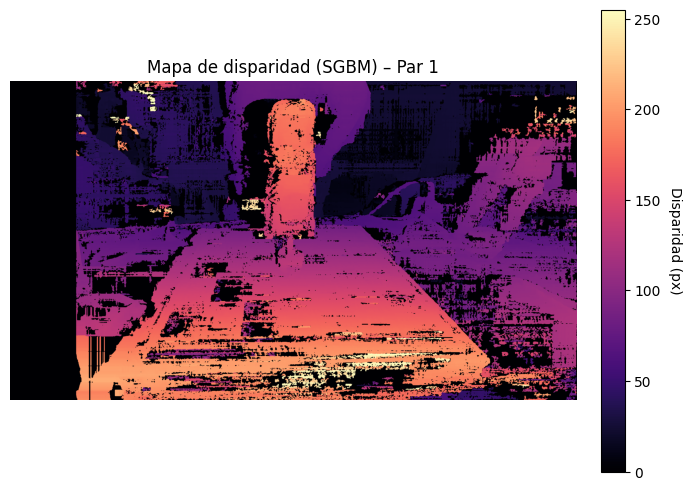

SGBM – Par 2 → min: -16.0, max: 3568.0


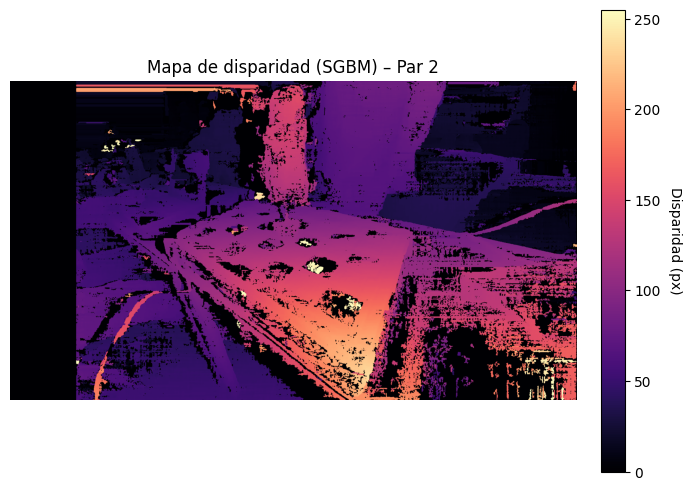

SGBM – Par 3 → min: -16.0, max: 3568.0


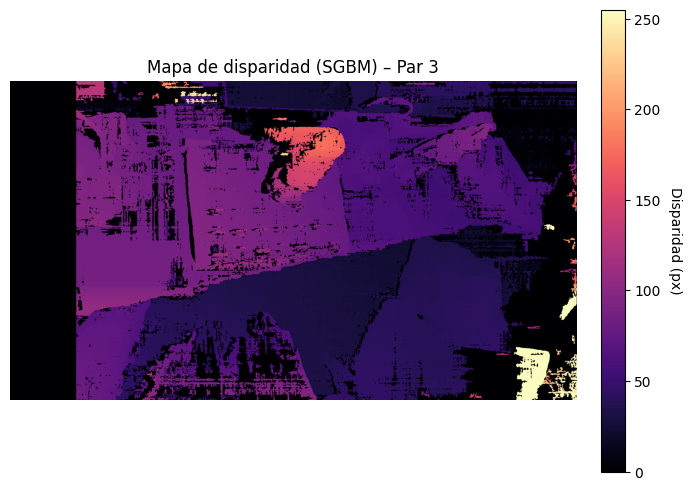

In [72]:
# --- SGBM ---
for idx, (left_path, right_path) in zip(pares_indices, pares_imgs):
    imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

    disp_raw, disp_vis = calcular_mapa_disparidad(
        imgL, imgR,
        build_matcher_fn=make_sgbm,
        min_disp=0,
        num_disp=16*14,
        block=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=8,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    print(f"SGBM – Par {idx+1} → min: {disp_raw.min():.1f}, max: {disp_raw.max():.1f}")

    plt.figure(figsize=(8,6))
    im = plt.imshow(disp_vis, cmap="magma")
    plt.title(f"Mapa de disparidad (SGBM) – Par {idx+1}")
    plt.axis("off")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Disparidad (px)", rotation=270, labelpad=15)
    plt.show()


#### Busqueda de Hiperparametros SGBM 

In [73]:
sgbm_grid = {
    "num_disp": [16*12, 16*14, 16*16, 16*20],
    "block":    [3, 5, 7],
    "uniquenessRatio": [8, 12],
    # podés sumar variantes de speckle y P1/P2 si querés
}

def grid_search_sgbm(pares_imgs, n_eval=3):
    results = []
    subset = pares_imgs[:n_eval]
    keys, values = zip(*sgbm_grid.items())
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        params.update({
            "min_disp": 0,
            "speckleWindowSize": 100,
            "speckleRange": 32,
            "preFilterCap": 63,
            # P1, P2 por defecto para GRAY (1 canal)
            "P1": 8 * 1 * (params["block"]**2),
            "P2": 32 * 1 * (params["block"]**2),
        })
        acc = defaultdict(float)
        for (lp, rp) in subset:
            imgL = cv2.imread(lp, cv2.IMREAD_GRAYSCALE)
            imgR = cv2.imread(rp, cv2.IMREAD_GRAYSCALE)
            try:
                m = evaluate_matcher(imgL, imgR, make_sgbm, **params)
            except AssertionError:
                continue
            acc["time_s"]     += m["time_s"]
            acc["pct_valid"]  += m["pct_valid"]
            acc["smooth"]     += m["smooth"]

        k = len(subset)
        if k == 0: 
            continue
        acc = {k_: v_/k for k_, v_ in acc.items()}
        score = acc["pct_valid"] + 1000*acc["smooth"] - 10*acc["time_s"]
        results.append({**params, **acc, "score": score})

    results_sorted = sorted(results, key=lambda r: r["score"], reverse=True)
    best = results_sorted[0] if results_sorted else None
    return best, results_sorted


In [74]:
best_sgbm, table_sgbm = grid_search_sgbm(pares_imgs, n_eval=3)
print("MEJOR SGBM:", best_sgbm)
for row in table_sgbm[:5]:
    print(row)


MEJOR SGBM: {'num_disp': 192, 'block': 7, 'uniquenessRatio': 8, 'min_disp': 0, 'speckleWindowSize': 100, 'speckleRange': 32, 'preFilterCap': 63, 'P1': 392, 'P2': 1568, 'time_s': 0.08513061205546062, 'pct_valid': 62.786265432098766, 'smooth': np.float32(5.49111e-05), 'score': np.float32(61.989872)}
{'num_disp': 192, 'block': 7, 'uniquenessRatio': 8, 'min_disp': 0, 'speckleWindowSize': 100, 'speckleRange': 32, 'preFilterCap': 63, 'P1': 392, 'P2': 1568, 'time_s': 0.08513061205546062, 'pct_valid': 62.786265432098766, 'smooth': np.float32(5.49111e-05), 'score': np.float32(61.989872)}
{'num_disp': 192, 'block': 5, 'uniquenessRatio': 8, 'min_disp': 0, 'speckleWindowSize': 100, 'speckleRange': 32, 'preFilterCap': 63, 'P1': 200, 'P2': 800, 'time_s': 0.08569590250651042, 'pct_valid': 61.46357381687243, 'smooth': np.float32(5.3672906e-05), 'score': np.float32(60.660286)}
{'num_disp': 224, 'block': 7, 'uniquenessRatio': 8, 'min_disp': 0, 'speckleWindowSize': 100, 'speckleRange': 32, 'preFilterCap'

### Comparación BM y SGBM

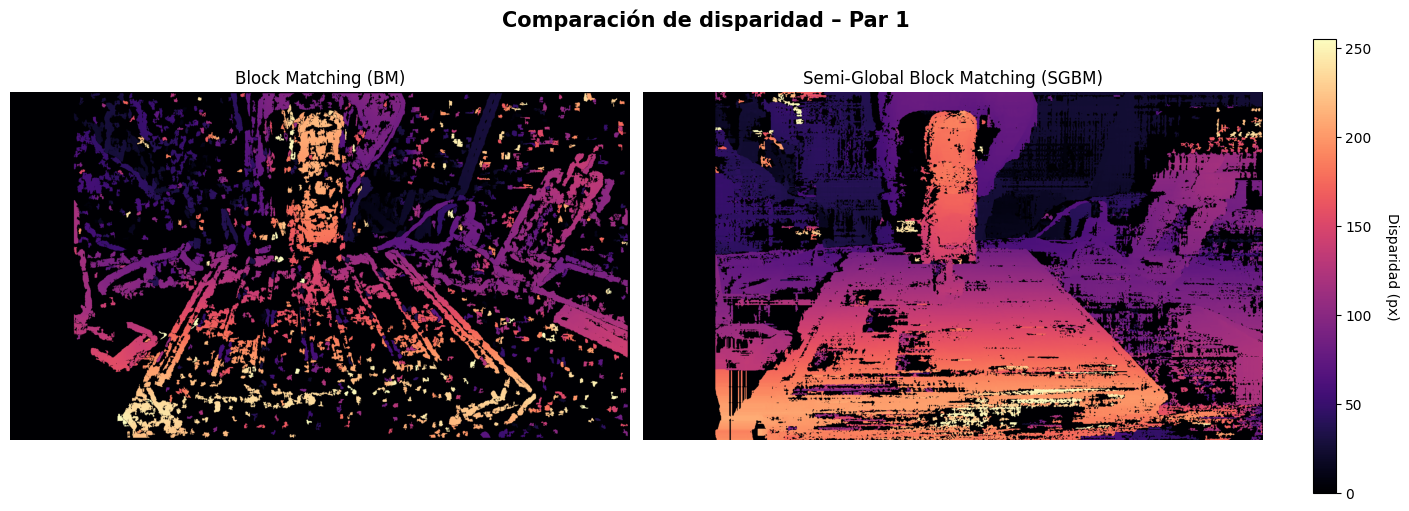

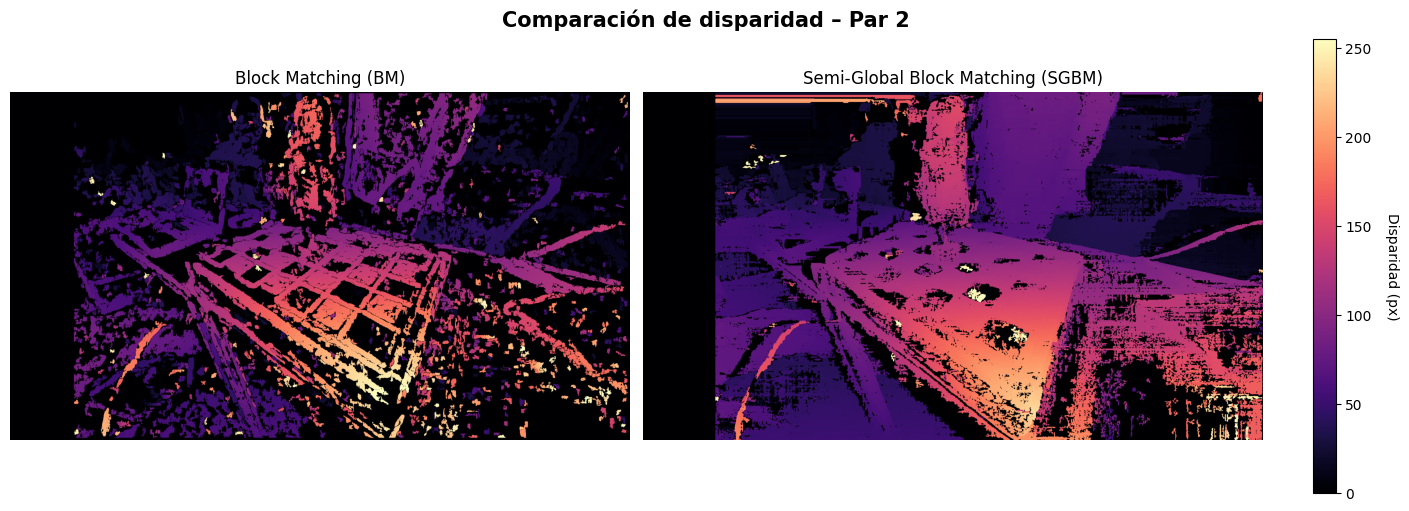

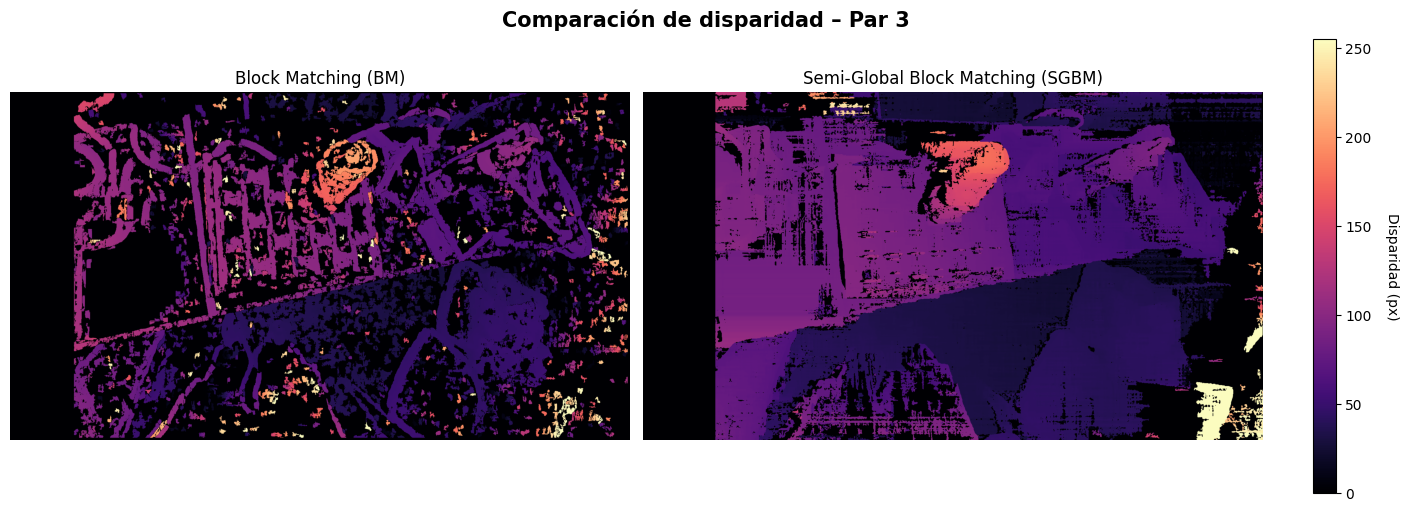

In [75]:
for idx, (left_path, right_path) in zip(pares_indices, pares_imgs):
    imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

    # --- BM ---
    disp_bm_raw, disp_bm_vis = calcular_mapa_disparidad(
        imgL, imgR,
        build_matcher_fn=make_bm,
        num_disp=16*12,
        block=15,
        textureThreshold=10,
        uniquenessRatio=5,
        speckleRange=32,
        speckleWindowSize=100
    )

    # --- SGBM ---
    disp_sgbm_raw, disp_sgbm_vis = calcular_mapa_disparidad(
        imgL, imgR,
        build_matcher_fn=make_sgbm,
        min_disp=0,
        num_disp=16*14,
        block=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=8,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # --- Figura comparativa ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    fig.suptitle(f"Comparación de disparidad – Par {idx+1}", fontsize=15, weight='bold')

    # Escala compartida para comparación justa
    vmin = min(disp_bm_vis.min(), disp_sgbm_vis.min())
    vmax = max(disp_bm_vis.max(), disp_sgbm_vis.max())

    im1 = axes[0].imshow(disp_bm_vis, cmap="magma", vmin=vmin, vmax=vmax)
    axes[0].set_title("Block Matching (BM)", fontsize=12)
    axes[0].axis("off")

    im2 = axes[1].imshow(disp_sgbm_vis, cmap="magma", vmin=vmin, vmax=vmax)
    axes[1].set_title("Semi-Global Block Matching (SGBM)", fontsize=12)
    axes[1].axis("off")

    # --- Barra de color más ancha y alineada ---
    cbar = fig.colorbar(im2, ax=axes, orientation="vertical", fraction=0.025, pad=0.04)
    cbar.set_label("Disparidad (px)", rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=10)

    plt.show()


#### Comparacion con Mejores Hiperparametros

score  pct_valid    smooth    time_s  num_disp  block  \
0  36.851383  37.083767  0.000043  0.027527       160     19   
1  36.791725  37.031797  0.000043  0.028314       160     19   
2  36.715881  36.953012  0.000043  0.028038       160     19   
3  35.923401  36.170685  0.000053  0.030074       192     19   
4  35.862541  36.128472  0.000054  0.031955       192     19   

   textureThreshold  uniquenessRatio  speckleRange  speckleWindowSize  
0                 5                5            32                100  
1                10                5            32                100  
2                20                5            32                100  
3                 5                5            32                100  
4                10                5            32                100

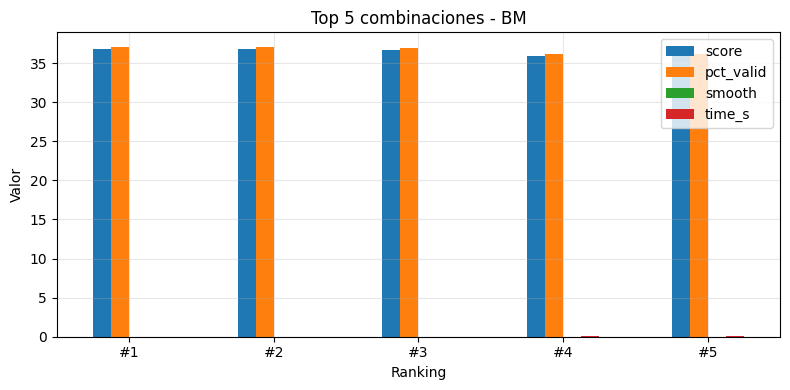

score  pct_valid    smooth    time_s  num_disp  block  uniquenessRatio  \
0  61.989872  62.786265  0.000055  0.085131       192      7                8   
1  60.660286  61.463574  0.000054  0.085696       192      5                8   
2  60.197014  61.063448  0.000071  0.093722       224      7                8   
3  59.774582  60.581356  0.000054  0.086092       192      3                8   
4  58.778805  59.659111  0.000070  0.095003       224      5                8   

   min_disp  speckleWindowSize  speckleRange  preFilterCap   P1    P2  
0         0                100            32            63  392  1568  
1         0                100            32            63  200   800  
2         0                100            32            63  392  1568  
3         0                100            32            63   72   288  
4         0                100            32            63  200   800

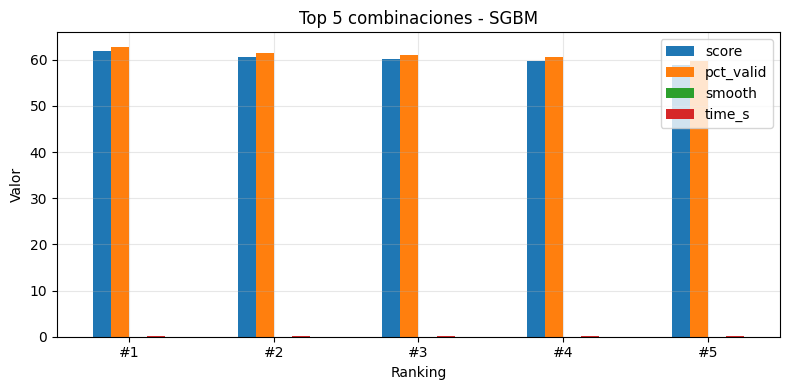

In [76]:
def visualizar_top(results, metodo="BM", top_n=5):
    """
    Muestra el TOP N resultados de la búsqueda de hiperparámetros.
    Incluye tabla ordenada y gráfico de barras con las 3 métricas principales.
    """
    if not results:
        print("⚠️ No hay resultados para mostrar.")
        return
    
    # Convertir a DataFrame y ordenar
    df = pd.DataFrame(results).sort_values("score", ascending=False).head(top_n)
    display(df[["score", "pct_valid", "smooth", "time_s"] + 
              [c for c in df.columns if c not in ["score","pct_valid","smooth","time_s"]]])
    
    # Gráfico de barras: comparación visual
    fig, ax1 = plt.subplots(figsize=(8,4))
    df_plot = df[["score", "pct_valid", "smooth", "time_s"]]
    df_plot.plot(kind="bar", ax=ax1)
    plt.title(f"Top {top_n} combinaciones - {metodo}")
    plt.xticks(range(top_n), [f"#{i+1}" for i in range(top_n)], rotation=0)
    plt.xlabel("Ranking")
    plt.ylabel("Valor")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 👉 Ejemplo de uso:
visualizar_top(table_bm, metodo="BM", top_n=5)
visualizar_top(table_sgbm, metodo="SGBM", top_n=5)


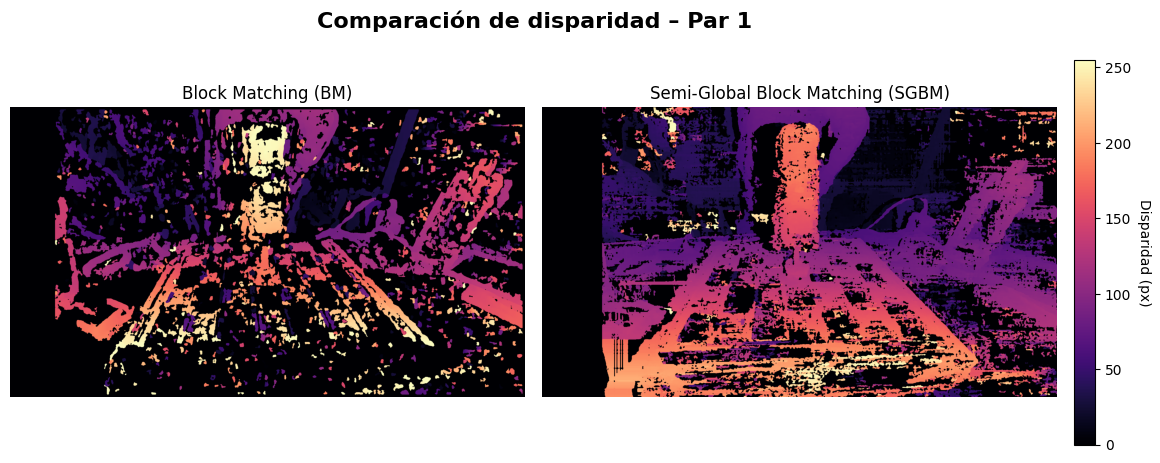

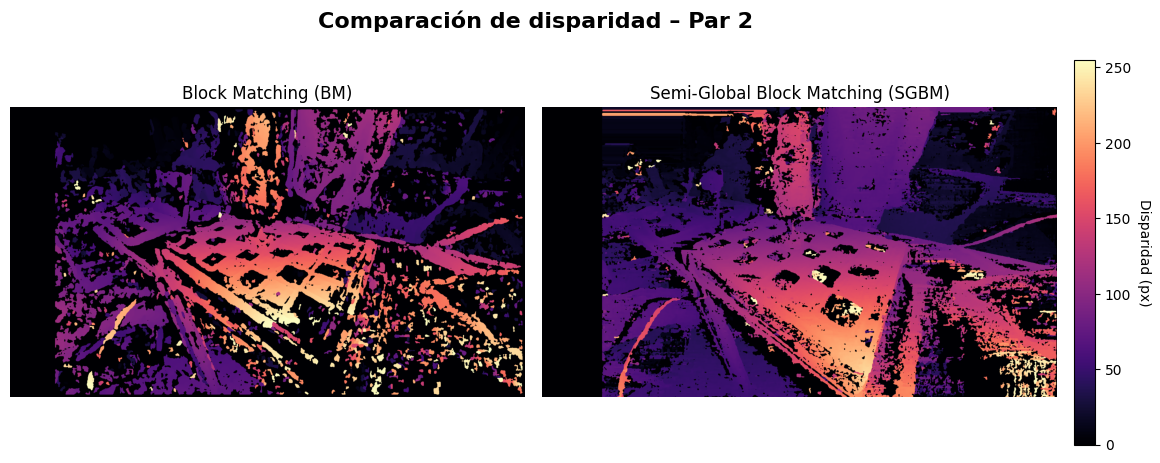

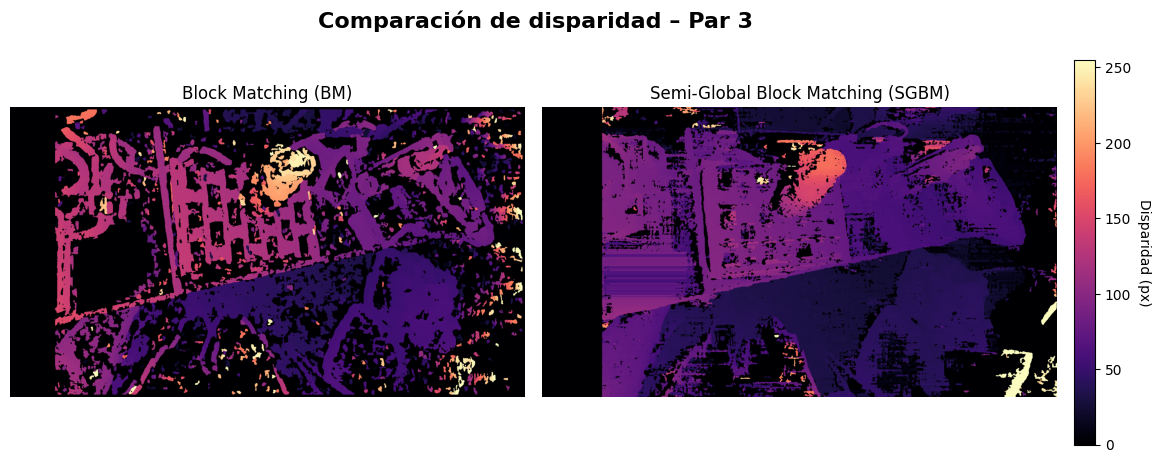

In [77]:
def fig_compare_pair(pares_imgs, idx_ref, bm_params, sgbm_params, cmap="magma"):
    L, R = pares_imgs[idx_ref]
    imgL = cv2.imread(L, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(R, cv2.IMREAD_GRAYSCALE)

    # BM
    disp_bm = make_bm(**bm_params).compute(imgL, imgR)
    vis_bm  = cv2.normalize(disp_bm, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    vis_bm  = cv2.medianBlur(vis_bm, 5)

    # SGBM
    disp_sg = make_sgbm(**sgbm_params).compute(imgL, imgR)
    vis_sg  = cv2.normalize(disp_sg, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    vis_sg  = cv2.medianBlur(vis_sg, 5)

    vmin = int(min(vis_bm.min(), vis_sg.min()))
    vmax = int(max(vis_bm.max(), vis_sg.max()))

    fig = plt.figure(figsize=(14, 5))
    gs  = GridSpec(1, 3, width_ratios=[1,1,0.04], wspace=0.05, figure=fig)
    fig.suptitle(f"Comparación de disparidad – Par {idx_ref+1}", fontsize=16, weight="bold", y=0.98)

    ax1 = fig.add_subplot(gs[0,0]); im1 = ax1.imshow(vis_bm, cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title("Block Matching (BM)", fontsize=12); ax1.axis("off")

    ax2 = fig.add_subplot(gs[0,1]); im2 = ax2.imshow(vis_sg, cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.set_title("Semi-Global Block Matching (SGBM)", fontsize=12); ax2.axis("off")

    cax = fig.add_subplot(gs[0,2])
    cbar = fig.colorbar(im2, cax=cax); cbar.set_label("Disparidad (px)", rotation=270, labelpad=14)
    plt.show()

# === Parámetros “ganadores” (tomá los que te dio tu Top) ===
# Ejemplo razonable (ajustá con tu top real):
bm_best    = {"num_disp": 16*10, "block": 19, "textureThreshold": 10, "uniquenessRatio": 5,
              "speckleRange": 32, "speckleWindowSize": 100}
sgbm_best  = {"min_disp": 0, "num_disp": 16*14, "block": 5,
              "P1": 8*1*5**2, "P2": 32*1*5**2, "uniquenessRatio": 8,
              "speckleWindowSize": 100, "speckleRange": 32, "preFilterCap": 63}

# === Figuras comparativas (como tus capturas) ===
fig_compare_pair(pares_imgs, idx_ref=0, bm_params=bm_best,   sgbm_params=sgbm_best)  # Par 1
fig_compare_pair(pares_imgs, idx_ref=1, bm_params=bm_best,   sgbm_params=sgbm_best)  # Par 2
fig_compare_pair(pares_imgs, idx_ref=2, bm_params=bm_best,   sgbm_params=sgbm_best)  # Par 3
